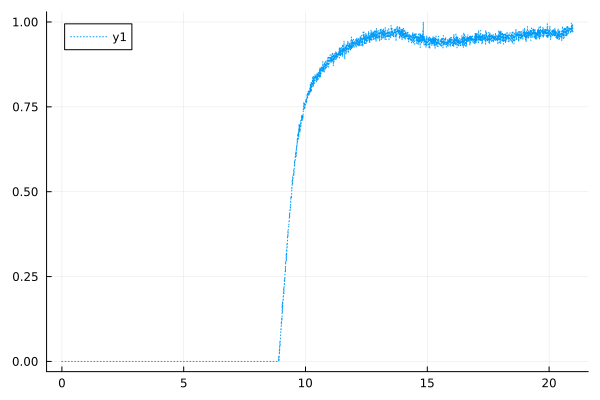

In [76]:
using XLSX
df = XLSX.readtable("../Lewatit_dry_BTC.xlsx", 1) |> DataFrame
plot(df[:, "Time h)"], df[:, "CO2"], ls=:dot)

In [71]:
include("../src/AdsorptionModel.jl")

RH=0.55
adsorption = OperatingParameters(;
                    step_name = Adsorption,
                    u_feed = 7.06*1e-2,
                    T_feed = 288.15,
                    T_amb = 288.15,
                    P_out = 1.01325e5,
                    y_CO2_feed = 0.0004,
                    y_H2O_feed = RH*Psat_H2O(288.15-273)/(1.01325e5),
                    duration = 8000)

heating = OperatingParameters(;
                step_name = Heating,
                u_feed = 0.0,
                T_feed = 288.15,
                T_amb = 373.15,
                P_out = 0.2e5,
                y_CO2_feed = 0.0,
                y_H2O_feed = 1.0,
                duration = 2400)

desorption = OperatingParameters(;
                step_name = Desorption,
                u_feed = 0.0,
                T_amb = 373.15,
                T_feed = 373.15,
                P_out = 0.2e5,
                y_CO2_feed = 0.0,
                y_H2O_feed = 1.0,
                duration = 20000)

cooling = OperatingParameters(;
            step_name = Cooling,
            u_feed = 0.0,
            T_amb = 288.15,
            T_feed = 120+273,
            P_out = 0.2e5,
            y_CO2_feed = 0.0,
            y_H2O_feed = 1.0,
            duration = 400)

pressurization = OperatingParameters(;
                    step_name = Pressurization,
                    u_feed = 0,
                    T_amb = 288.15,
                    T_feed = 288.15,
                    P_out = 1.01325e5,
                    y_CO2_feed = 0.0004,
                    y_H2O_feed = 0.0095,
                    duration = 30)

pressurization_reset = OperatingParameters(;
                    step_name = PressurizationReset,
                    u_feed = 0,
                    T_amb = 288.15,
                    T_feed = 288.15,
                    P_out = 1.01325e5,
                    y_CO2_feed = 0.0004,
                    y_H2O_feed = 0.0095,
                    duration = 0.0)

cycle_steps = [adsorption, heating, desorption, cooling, pressurization]
num_cycles = 4
@time sol, index_data = run_simulation(;N=10, cycle_steps, num_cycles)

Running step Adsorption
Running step Heating
Running step Desorption
Running step Cooling
Running step Pressurization
Running step Adsorption
Running step Heating
Running step Desorption
Running step Cooling
Running step Pressurization
Running step Adsorption
Running step Heating
Running step Desorption
Running step Cooling
Running step Pressurization
Running step Adsorption
Running step Heating
Running step Desorption
Running step Cooling
Running step Pressurization
  2.854136 seconds (60.45 M allocations: 4.328 GiB, 20.67% gc time, 19.77% compilation time: 70% of which was recompilation)


(Main.sol, AdsorptionData(1, 2, 3, 4, 5, 6, 7, 8, 1, 2, OperatingParameters(0.0, 288.15, 288.15, 0.0004, 0.0095, 30.0, Pressurization, 101325.0, var"#430#433"{AdsorptionData, OperatingParameters}(Core.Box([52.97374055089129, 0.4511078951610439, 1.4462232084969393, 346.29355138932726, 97728.52438588526, 288.1860804785891, 0.7290763758639219, 0.3454261189403433, 32.714730035299944, 0.28221410273562714  …  0.7332716201086084, 0.3552196041056787, 32.590756323419534, 0.29774969232694193, 0.950669420663966, 347.3693718758192, 97728.51853498092, 288.18674854028393, 0.7333990318930159, 0.35558155364871075]), AdsorptionData(#= circular reference @-3 =#), OperatingParameters(0.0, 288.15, 288.15, 0.0004, 0.0095, 30.0, Pressurization, 101325.0, var"#430#433"{AdsorptionData, OperatingParameters}(#= circular reference @-2 =#), 0.9901000000000001, 42.29489667460054, 41.876177197522, 0.016917958669840215, 0.4018015184087051, 9.1e-6, 1235.9463387677843, 0.011247111682786836)), 0.9901000000000001, 42.29

8000 + 2400 + 20000 + 400 = 30800
30830.0


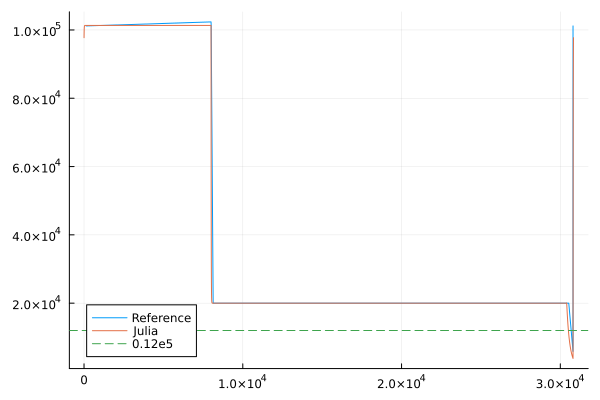

In [72]:
using CSV
using DataFrames

duration_per_cycle = sum([s.duration for s in cycle_steps])
@show 8000 + 2400 + 20000 + 400
println(duration_per_cycle)
last_cycle = duration_per_cycle*3 : duration_per_cycle*4
df = CSV.File("../Young_2021/pressure.csv") |> DataFrame
plot(df[:, :x], df[:, " y"] .* 1e5, label="Reference")
plot!([sol(t)[index_data.ip, end] for t in last_cycle], label="Julia")
hline!([0.12e5], linestyle=:dash, label="0.12e5")

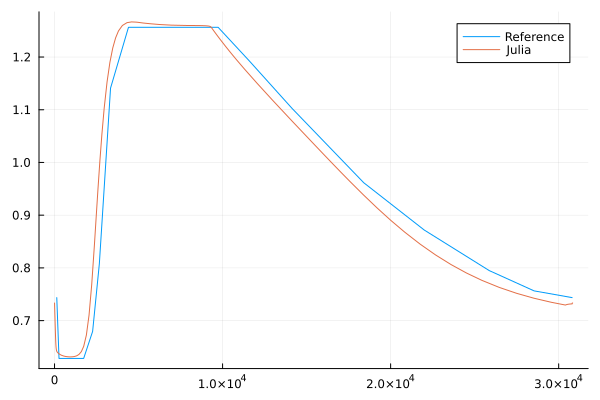

In [54]:
df = CSV.File("../Young_2021/qco2.csv") |> DataFrame
plot(df[:, :x], df[:, " y"], label="Reference")
plot!([sol(t)[index_data.iq_CO2, end] for t in last_cycle], label="Julia")

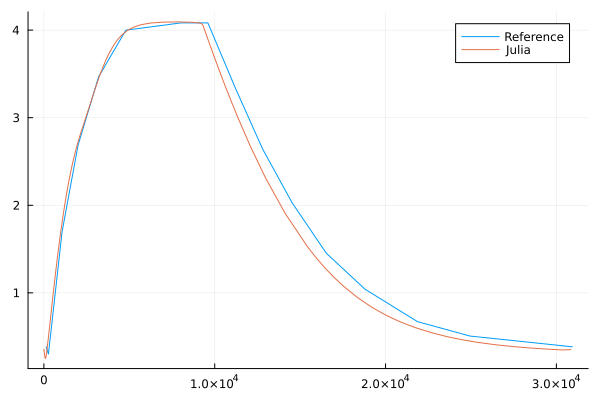

In [55]:
df = CSV.File("../Young_2021/qh2o.csv") |> DataFrame
plot(df[:, :x], df[:, " y"], label="Reference")
plot!([sol(t)[index_data.iq_H2O, end] for t in last_cycle], label="Julia")

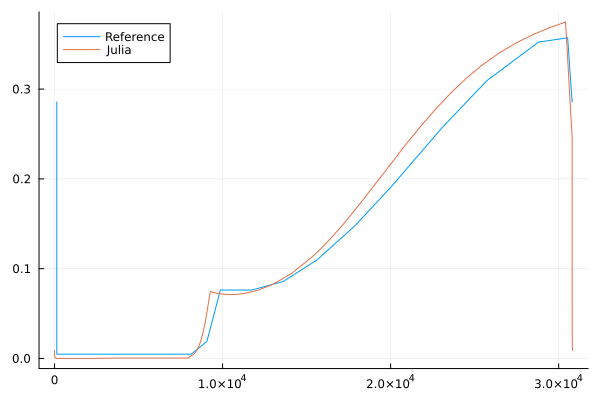

In [56]:
df = CSV.File("../Young_2021/yco2.csv") |> DataFrame
plot(df[:, :x], df[:, " y"], label="Reference")

plot!([sol(t)[index_data.iCO2, end] / (sol(t)[index_data.iN2, end] + sol(t)[index_data.iH2O, end] + sol(t)[index_data.iCO2, end]) for t in last_cycle], label="Julia")

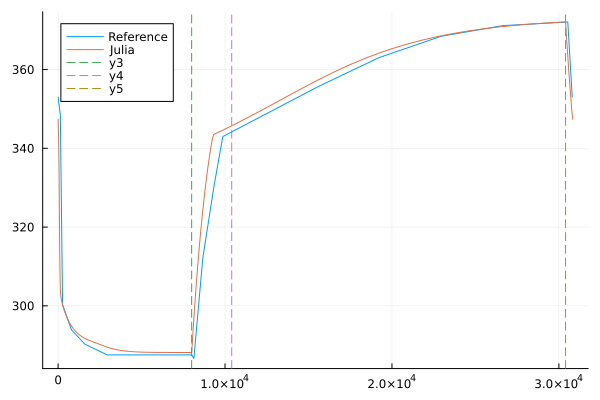

In [73]:
df = CSV.File("../Young_2021/T.csv") |> DataFrame
plot(df[:, :x], df[:, " y"], label="Reference")
plot!([sol(t)[index_data.iT, end] for t in last_cycle], label="Julia")
vline!([8000], linestyle=:dash)
vline!([8000+2400], linestyle=:dash)
vline!([8000+2400+20000], linestyle=:dash)

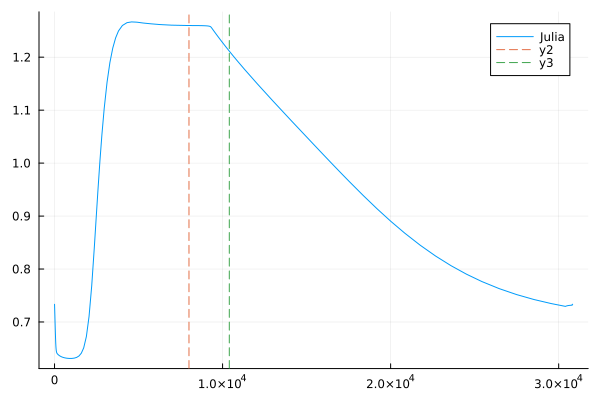

In [65]:
plot([sol(t)[index_data.iq_CO2, end] for t in last_cycle], label="Julia")
vline!([8000], linestyle=:dash)
vline!([8000+2400], linestyle=:dash)